In [43]:
!pip install catboost
!pip install pytorch-tabnet

In [44]:
import matplotlib
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import defaultdict
from sklearn.metrics import roc_curve, auc
import os
import pathlib
import tempfile

import openpyxl.drawing.image
from openpyxl.formatting.rule import ColorScaleRule
from openpyxl.utils.dataframe import dataframe_to_rows
from sklearn.metrics import roc_auc_score

import catboost
from catboost import CatBoostClassifier

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [45]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)


def generate_classification_report(
    y_true: np.ndarray, y_pred: np.ndarray, y_pred_scored: np.ndarray, beta: float
) -> pd.DataFrame:
    """Generates pandas-based per-class and aggregated classification metrics.
    Args:
        y_true: ground truth labels
        y_pred:  predicted model labels
    Returns:
        pandas dataframe with main classification metrics
    """
    metrics = defaultdict(lambda: {})
    metrics_names = [
        "precision",
        "recall",
        "f1-score",
        "auc",
        "support",
        "support (%)",
    ]
    avg_names = ["macro", "micro", "weighted"]
    labels = sorted(set(y_true).union(y_pred))
    auc = np.zeros(len(labels))
    for i, label in enumerate(labels):
      auc[i] = roc_auc_score((y_true==label).astype(int), y_pred_scored[:, i])
    
    
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true=y_true, y_pred=y_pred, average=None, labels=labels,
    )

    r_support = support / support.sum()
    for i, average in enumerate(avg_names):
      avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, average=average, labels=labels,
        )
       
      avg_metrics = avg_precision, avg_recall, avg_f1
      for k, v in zip(metrics_names[:4], avg_metrics):
          metrics[k][average] = v

    report = pd.DataFrame(
        [precision, recall, f1, auc, support, r_support],
        columns=labels,
        index=metrics_names,
    ).T

    if beta:
      _, _, fbeta, _ = precision_recall_fscore_support(
          y_true=y_true, y_pred=y_pred, average=None, beta = beta, labels=labels,
      )
      avg_fbeta = np.zeros(len(avg_names))
      for i, average in enumerate(avg_names):
        _, _, avg_beta, _ = precision_recall_fscore_support(
              y_true=y_true,
              y_pred=y_pred,
              average=average,
              beta=beta,
              labels=labels,
          )
        avg_fbeta[i] = avg_beta
      report.insert(3, "f-beta", fbeta, True)

    metrics["support"]["macro"] = support.sum()
    metrics["precision"]["accuracy"] = accuracy
    metrics["auc"]["macro"] = roc_auc_score(y_test, y_pred_scored, multi_class="ovr", average = "macro")
    metrics["auc"]["weighted"] = roc_auc_score(y_test, y_pred_scored, multi_class="ovr", average = "weighted")
    metrics = pd.DataFrame(metrics, index=avg_names + ["accuracy"])

    result = pd.concat((report, metrics)).fillna("")
    
    # result = result[metrics_names]
    if beta:
      result["f-beta"]["macro"] = avg_fbeta[0]
      result["f-beta"]["micro"] = avg_fbeta[1]
      result["f-beta"]["weighted"] = avg_fbeta[2]
    return result



def plot_confusion_matrix_heatmap(
    true: np.ndarray, predicted: np.ndarray
) -> None:
    """Plots confusion matrix with seaborn.
    Args:
        true: ground truth labels
        predicted: predicted model labels
    """
    classes = sorted(np.unique(true))
    matrix = confusion_matrix(true, predicted, labels=classes)
    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
    matrix = matrix.round(decimals=2)
    sns.heatmap(
        matrix,
        xticklabels=classes,
        yticklabels=classes,
        annot=True,
        fmt="g",
        square=True,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
train_data = pd.read_csv('/content/drive/My Drive/data.forest/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/data.forest/test.csv')
# train_data = pd.read_csv("train\\train.csv")
# test_data = pd.read_csv("test\\test.csv")

In [48]:
train_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [49]:
X=train_data.drop(labels=['Id','Cover_Type'],axis=1)
y=train_data['Cover_Type']

**Train Test Split**

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.2, random_state=40)
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

**Sklearn RidgeClassifier**

In [51]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

rc = RidgeClassifier()
rc.fit(X_train, y_train)
pred = rc.predict(X_test)
decision_func = rc.decision_function(X_test)

In [52]:
y_pred_scored = np.array([])
for i, dec in enumerate(decision_func):
  soft = np.exp(decision_func[i]) / np.sum(np.exp(decision_func[i])) 
  y_pred_scored = np.append(y_pred_scored, soft)
y_pred_scored = y_pred_scored.reshape(-1, 7)



In [53]:
confusion_matrix(y_test, pred)

array([[283,  82,   1,   0,  32,   1,  41],
       [128, 201,   4,   2,  94,  13,   5],
       [  0,   0, 196,  67,  16, 141,   0],
       [  0,   0,  41, 367,   0,  48,   0],
       [ 24,  52,  33,  18, 279,  20,   0],
       [  1,  15,  76,  51,  33, 231,   0],
       [ 81,   1,   3,   0,   3,   0, 340]])

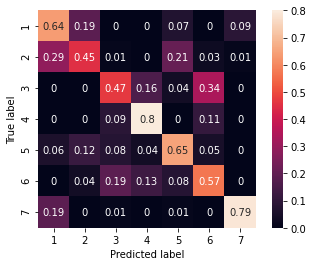

In [54]:
plot_confusion_matrix_heatmap(y_test, pred)

In [55]:
generate_classification_report(y_test, pred, y_pred_scored, beta = None)

,precision,recall,f1-score,auc,support,support (%)
1,0.547389,0.643182,0.591432,0.904735,440,0.145503
2,0.572650,0.449664,0.503759,0.884956,447,0.147817
3,0.553672,0.466667,0.50646,0.901004,420,0.138889
4,0.726733,0.804825,0.763788,0.978525,456,0.150794
5,0.610503,0.65493,0.631937,0.917611,426,0.140873
6,0.508811,0.567568,0.536585,0.908096,407,0.13459
7,0.880829,0.794393,0.835381,0.983379,428,0.141534
macro,0.628655,0.62589,0.624192,0.925472,3024,
micro,0.627315,0.627315,0.627315,,,
weighted,0.629932,0.627315,0.625512,0.925817,,


**Sklearn KNeighborsClassifier**

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
y_pred_scored = knn.predict_proba(X_test)

In [57]:
confusion_matrix(y_test, pred)

array([[291,  71,   2,   0,  20,   0,  56],
       [107, 239,  18,   0,  48,  23,  12],
       [  0,   4, 324,  29,   5,  58,   0],
       [  0,   0,   9, 436,   0,  11,   0],
       [  1,   4,  12,   0, 404,   5,   0],
       [  1,   3,  38,  19,   8, 338,   0],
       [ 12,   5,   0,   0,   0,   0, 411]])

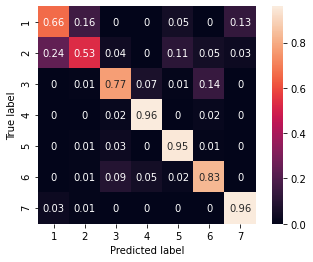

In [58]:
plot_confusion_matrix_heatmap(y_test, pred)

In [59]:
generate_classification_report(y_test, pred, y_pred_scored, beta = None)

,precision,recall,f1-score,auc,support,support (%)
1,0.706311,0.661364,0.683099,0.920271,440,0.145503
2,0.733129,0.534676,0.61837,0.879207,447,0.147817
3,0.803970,0.771429,0.787363,0.954022,420,0.138889
4,0.900826,0.95614,0.92766,0.994442,456,0.150794
5,0.832990,0.948357,0.886937,0.992346,426,0.140873
6,0.777011,0.830467,0.80285,0.967635,407,0.13459
7,0.858038,0.96028,0.906284,0.991159,428,0.141534
macro,0.801754,0.808959,0.801795,0.957012,3024,
micro,0.807870,0.80787,0.80787,,,
weighted,0.802006,0.80787,0.801311,0.956634,,


**CatBoost**

In [60]:
# метрика 'MultiClass' <!-- ![image.png](attachment:5ad94b38-4bda-4fa0-af10-8f3b7ea74396.png)

In [61]:
%%time
ctb = CatBoostClassifier(iterations=1000, loss_function = 'MultiClass')
ctb.fit(X_train, y_train, verbose=False, plot=True)
pred = ctb.predict(X_test)
y_pred_scored = ctb.predict_proba(X_test)
print("accuracy :", ctb.score(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

accuracy : 0.8525132275132276
CPU times: user 48.8 s, sys: 1.17 s, total: 50 s
Wall time: 26.9 s


In [62]:
confusion_matrix(y_test, pred)

array([[338,  71,   0,   0,   5,   1,  25],
       [ 89, 299,  12,   0,  33,   7,   7],
       [  0,   0, 343,  15,   6,  56,   0],
       [  0,   0,   9, 441,   0,   6,   0],
       [  0,  19,  10,   0, 388,   9,   0],
       [  2,   2,  32,   8,   2, 361,   0],
       [ 19,   1,   0,   0,   0,   0, 408]])

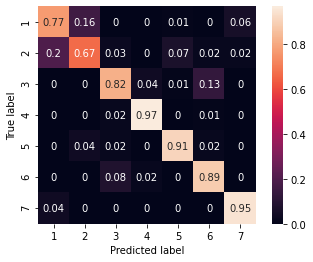

In [63]:
plot_confusion_matrix_heatmap(y_test, pred)

In [64]:
pred = pred.ravel()

In [65]:
generate_classification_report(y_test, pred, y_pred_scored, beta = None)

,precision,recall,f1-score,auc,support,support (%)
1,0.754464,0.768182,0.761261,0.970807,440,0.145503
2,0.762755,0.668904,0.712753,0.955936,447,0.147817
3,0.844828,0.816667,0.830508,0.983331,420,0.138889
4,0.950431,0.967105,0.958696,0.99847,456,0.150794
5,0.894009,0.910798,0.902326,0.994562,426,0.140873
6,0.820455,0.886978,0.85242,0.987199,407,0.13459
7,0.927273,0.953271,0.940092,0.997162,428,0.141534
macro,0.850602,0.853129,0.851151,0.983924,3024,
micro,0.852513,0.852513,0.852513,,,
weighted,0.850789,0.852513,0.850932,0.983802,,


**TabNet**

In [66]:
tbn = TabNetClassifier(n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam
   )

Device used : cpu


In [67]:
tbn.fit(X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    max_epochs=1000, patience=100,
    batch_size=1000, virtual_batch_size=256)
pred = tbn.predict(X_test)

epoch 0  | loss: 2.14849 | train_accuracy: 0.24876 | valid_accuracy: 0.24702 |  0:00:06s
epoch 1  | loss: 1.31719 | train_accuracy: 0.19403 | valid_accuracy: 0.19279 |  0:00:12s
epoch 2  | loss: 1.19375 | train_accuracy: 0.24529 | valid_accuracy: 0.23975 |  0:00:18s
epoch 3  | loss: 1.09932 | train_accuracy: 0.36235 | valid_accuracy: 0.35417 |  0:00:24s
epoch 4  | loss: 1.00262 | train_accuracy: 0.33507 | valid_accuracy: 0.33896 |  0:00:31s
epoch 5  | loss: 0.95596 | train_accuracy: 0.36946 | valid_accuracy: 0.37004 |  0:00:37s
epoch 6  | loss: 0.92465 | train_accuracy: 0.37897 | valid_accuracy: 0.37698 |  0:00:43s
epoch 7  | loss: 0.91229 | train_accuracy: 0.35987 | valid_accuracy: 0.36442 |  0:00:49s
epoch 8  | loss: 0.88196 | train_accuracy: 0.1818  | valid_accuracy: 0.18585 |  0:00:55s
epoch 9  | loss: 0.8771  | train_accuracy: 0.23991 | valid_accuracy: 0.23082 |  0:01:01s
epoch 10 | loss: 0.85974 | train_accuracy: 0.22197 | valid_accuracy: 0.21296 |  0:01:08s
epoch 11 | loss: 0.84

KeyboardInterrupt: ignored

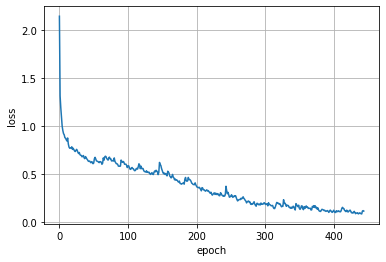

In [68]:
plt.plot(tbn.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

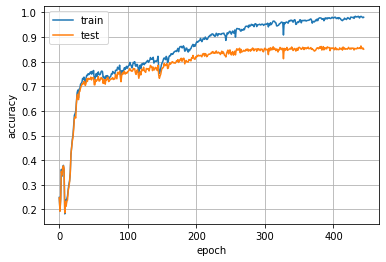

In [69]:
plt.plot(tbn.history['train_accuracy'], label = 'train')
plt.plot(tbn.history['valid_accuracy'], label = 'test')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

In [70]:
confusion_matrix(y_test, pred)

array([[338,  71,   0,   0,   5,   1,  25],
       [ 89, 299,  12,   0,  33,   7,   7],
       [  0,   0, 343,  15,   6,  56,   0],
       [  0,   0,   9, 441,   0,   6,   0],
       [  0,  19,  10,   0, 388,   9,   0],
       [  2,   2,  32,   8,   2, 361,   0],
       [ 19,   1,   0,   0,   0,   0, 408]])

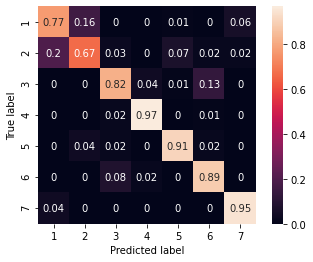

In [71]:
plot_confusion_matrix_heatmap(y_test, pred)

In [72]:
pred = pred.ravel()

In [73]:
generate_classification_report(y_test, pred, y_pred_scored, beta = None)

,precision,recall,f1-score,auc,support,support (%)
1,0.754464,0.768182,0.761261,0.970807,440,0.145503
2,0.762755,0.668904,0.712753,0.955936,447,0.147817
3,0.844828,0.816667,0.830508,0.983331,420,0.138889
4,0.950431,0.967105,0.958696,0.99847,456,0.150794
5,0.894009,0.910798,0.902326,0.994562,426,0.140873
6,0.820455,0.886978,0.85242,0.987199,407,0.13459
7,0.927273,0.953271,0.940092,0.997162,428,0.141534
macro,0.850602,0.853129,0.851151,0.983924,3024,
micro,0.852513,0.852513,0.852513,,,
weighted,0.850789,0.852513,0.850932,0.983802,,
